# 使用 ``brainmass`` 进行全脑神经质量模型建模

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chaobrain/brain-modeling-ecosystem/blob/main/docs/brainmass_Modeling_MEG_data_zh.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/chaobrain/brain-modeling-ecosystem/blob/main/docs/brainmass_Modeling_MEG_data_zh.ipynb)

我们的任务是使用brainmass来模拟MEG数据记录的功能连接性。具体实验流程是用我们构建好的wilson-Cowan模型进行建模，将得到的模拟数据和真实MEG数据做相同的一系列处理，之后分别计算功能连接矩阵，通过比较两组功能连接矩阵的相似性来得出模拟的效果。

## Introduction of Wilson-Cowan Model

Wilson-Cowan是一个描述神经元集体活动的模型，关注的不是单个神经元，而是将神经元群体简化成两个相互作用的神经元群，也就是兴奋性神经元群和抑制性神经元群。兴奋性神经元群的活动会对与其相连的其他神经元活动产生“激励”或“激活”，抑制性神经元群会对与其相连的其他神经元活动产生“抑制”。该模型的核心思想是通过一组微分方程来描述这两个群体的平均放电率，通过这种方式模拟产生的节律活动和我们真实大脑的活动有一定的相似性。

核心微分方程如下：

$$
\tau_E \dot E = -E + S_E(w_{EE} E - w_{EI} I + I_E + \xi_E)
$$

$$
\tau_I \dot I = -I + S_I(w_{IE} E - w_{II} I + I_I + \xi_I)
$$

| 数学符号                             | 代码变量                             | 含义             |
| -------------------------------- | -------------------------------- | -------------- |
| $E, I$                       | `self.rE.value`, `self.rI.value` | 兴奋/抑制群体平均放电率   |
| $\tau_E, \tau_I$                 | `self.tau_E`, `self.tau_I`       | 时间常数（ms 级），也就是响应速度     |
| $w_{EE}, w_{IE}, w_{EI}, w_{II}$ | 同名                               | 四种连接权重      |
| $r$                              | `self.r`                         | 不应期/自抑制强度      |
| $I_E(t), I_I(t)$                 | `rE_ext`, `rI_ext`               | 外部输入（可含噪声）     |
| $S_j(x)$                         | `self.S(x, a, theta)`            | S型响应函数         |

*S_E*(⋯)这一项表示的是通过S型响应函数总的外部输入，包括了其他神经元的输入和外部电流，响应函数的作用是将输入电流转换成放电率，-*E*是一个衰减项，描述的是没有外部输入、没有自抑制自激发的情况下，平均放电率会根据时间常数衰减到0。


## Single Node simulation

如何用Wilson-cowan模型进行单个节点的建模？单节点的建模模拟的是单个节点的兴奋-抑制回路。
首先我们先导入我们需要的一系列的工具：包括brainstate、braintools、brainunit以及其他的一些工具。

In [1]:
# 首先导入必要的工具
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import brainmass

brainstate.environ.set(dt=0.1 * u.ms)

首先生成0到5，45，步长为0.05的等差序列，共110个数值，作为110个独立的外部输入，之后一次性生成110个独立的节点，然后让这110个节点在各自恒定输入下并行跑10000个时间步，返回每个节点的兴奋性放电率并收集成一维数组。

首先使用brainmass.WilsonCowanModel调用我们分装好的Wilson-Cowan模型来进行节点的声明，因为是单点模拟，所以将size设置为1，使用brainmass.OUProcess来调用我们封装好的噪声模块，进行兴奋性群体和抑制性群体的噪声添加。
接下来让模型沿着10000个时间步自动积分，并且把每一个时间步得到的兴奋性发放率收集成一维数组exec_activity

In [2]:
node = brainmass.WilsonCowanModel(
    1,
    noise_E=brainmass.OUProcess(1, sigma=0.01, init=brainstate.init.ZeroInit()),
    noise_I=brainmass.OUProcess(1, sigma=0.01, init=brainstate.init.ZeroInit()),
)
brainstate.nn.init_all_states(node)

import numpy as np
def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return node.update(0.1)
indices = np.arange(10000)
exec_activity = brainstate.transform.for_loop(step_run, indices)

将得到的结果画图表示出来，横轴表示的是真实时间，纵轴表示的是我们得到的兴奋性发放率

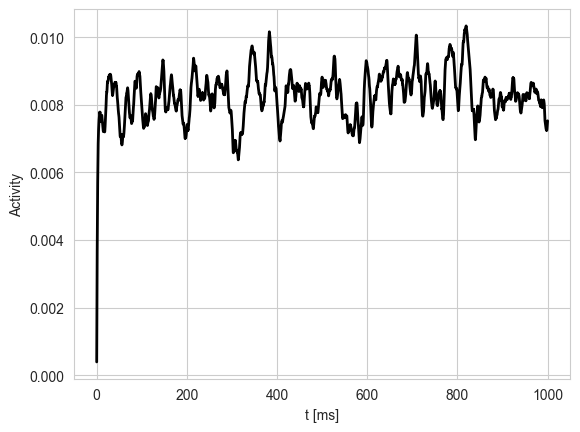

In [3]:
plt.plot(indices * brainstate.environ.get_dt(), exec_activity, c='k', lw=2)
plt.xlabel("t [ms]")
plt.ylabel("Activity")
plt.show()

## Bifucation diagram

我们可以通过封装好的模型来画出一个简单的一维系统分岔图，思路是一次性创建110个并行的独立节点，，每个节点赋予一个固定的直流输入，进行模拟之后记录各节点兴奋性平均放电率的的稳态最大值和最小值，画图表示。

首先生成0到5，45，步长为0.05的等差序列，共110个数值，作为110个独立的外部输入，之后一次性生成110个独立的节点，然后让这110个节点在各自恒定输入下并行跑10000个时间步，返回每个节点的兴奋性放电率并收集成一维数组。

In [4]:
import numpy as np

exc_inputs = np.arange(0, 5.5, 0.05)

nodes = brainmass.WilsonCowanModel(exc_inputs.size)
brainstate.nn.init_all_states(nodes)

def step_run(i):
    with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
        return nodes.update(exc_inputs)
indices = np.arange(10000)
exec_activity = brainstate.transform.for_loop(step_run, indices)

对每一个节点的平均放电率取稳态最大值和最小值，将所有结果绘制成曲线图表示。

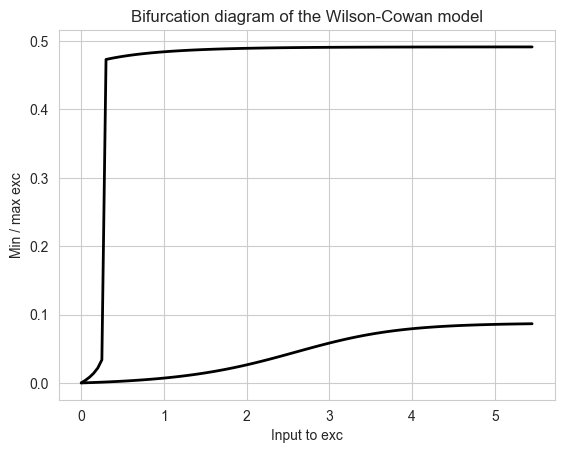

In [5]:
max_exc = exec_activity.max(axis=0)
min_exc = exec_activity.min(axis=0)

plt.plot(exc_inputs, max_exc, c='k', lw=2)
plt.plot(exc_inputs, min_exc, c='k', lw=2)
plt.title("Bifurcation diagram of the Wilson-Cowan model")
plt.xlabel("Input to exc")
plt.ylabel("Min / max exc")
plt.show()

## About Coupling


我们如何将单节点和其他节点进行耦合呢？常用的有两种基本的方式，一种是扩散耦合，一种是加性耦合，Wilson-Cowan模型用的是扩散耦合。
通用表达式是：

$$
current_i(t) = \sum_{j=0}^{N} \mathbf{g}(G_{ij}, \mathbf{x}_i(t), \mathbf{x}_j(t - D_{ij}))
$$

| 符号     | 形状  | 来源                        | 含义                                                 |
| ------ | --- | ------------------------- | -------------------------------------------------- |
| **𝑮** | N×N | DTI 追踪的**纤维束密度**或**连接概率** | Gᵢⱼ：从节点 j → i 的**解剖权重**（通常归一化到 \[0, 1] 或保留原始 FA 值） |
| **𝑫** | N×N | 纤维长度 ÷ 信号速度 (~5–10 m/s)   | Dᵢⱼ：j → i 的**轴突传导延迟**（单位 ms）                       |

扩散耦合的表达式是：

$$
\text{current}_i = k \cdot \sum_j g_{ij} \cdot (x_j - y_i)
$$

- ${current}_i$ : 目标脑区 i 接收到的净输入电流。

- $k$: 全局耦合强度，用于缩放整个网络的整体影响力。

- $g_{ij}$: 从源脑区 j 到目标脑区 i 的连接权重（来自连接矩阵）。

- $(\mathbf{x}_i(t), \mathbf{x}_j(t - D_{ij}))$：这一部分表示的是源脑区活动${x}_i(t)$与目标脑区活动${y}_i(t)$之间的差值，如果如果源脑区比目标脑区更活跃，该项为正，会“激发”或增加目标脑区的活动，如果为负，则会“抑制”或降低目标脑区的活动。
通过调整，相连节点脑区之间的活动差异会变小，从而促进同步或集体振荡。

加性耦合表达式：

$$
\text{current}_i = k \cdot \sum_j g_{ij} \cdot x_j
$$

脑区i接收到的输入完全由其邻居脑区的活动状态和连接强度决定，再由全局耦合强度 k 进行缩放，起到模拟前馈信息的效果。

## Brain Network

接下来我们来进行全脑的建模。全脑建模的通用方程如以下所示：

$$
\frac{d}{dt}\mathbf{x}_i(t) = \mathbf{f}(\mathbf{x}_i(t)) + \sum_{j=0}^{N} \mathbf{g}(G_{ij}, \mathbf{x}_i(t), \mathbf{x}_j(t - D_{ij})) + \boldsymbol{\mu}_i(t)
$$

也就是每个节点的状态变化 = 本地动力学 + 全局耦合 + 噪声

| 符号                | 尺寸 | 含义                                            |
| ----------------- | -- | --------------------------------------------- |
| **N**             | 标量 | 脑区（或节点）总数，例如 68（Desikan-Killiany 模板）或 90（AAL） |
| **i/j ∈ \[0, N−1]** | 索引 | 第 i/j 个脑区                     |

我们建模的主要区别取决于动力学模型不同，例如我们这个实验使用的是Wilson-Cowan这个模型，还有其他常用的模型如Hopf模型、Aln模型、wong_wang模型等，耦合函数进行的是跨节点的信息转换与传递，也就是将远处节点的状态作为当前计算节点的输入，这一块的计算方式也有不同的方法，主要有加法耦合、扩散耦合和非线性耦合。

我们需要导入结构性数据，可以使用dataset里面已经存放的hcp的DTI结构性数据，通常包括Cmat数据和Dmat数据，Cmat存储的是脑区之间的连接强度，Dmat存储的是脑区之间的纤维长度。
构建Network来进行全脑的建模，计算80个Wilson-Cowan节点，首先是得到连接强度和延迟时间，延迟时间由Dmat的纤维长度除以传导速度来得到，然后生成索引矩阵，沿连接边构建延迟视图。耦合的计算方式是扩散耦合，根据目标节点活动和延迟后的邻居节点活动计算输入，并按照全局耦合系数k进行缩放。最后整合所有节点的输入得到新的rE。

In [6]:
import os.path
import kagglehub
path = kagglehub.dataset_download("oujago/hcp-gw-data-samples")
hcp = braintools.file.msgpack_load(os.path.join(path, "hcp-data-sample.msgpack"))

Loading checkpoint from D:\Data\kagglehub\datasets\oujago\hcp-gw-data-samples\versions\1\hcp-data-sample.msgpack


In [7]:
class Network(brainstate.nn.Module):
    def __init__(self, signal_speed=2., k=1.):
        super().__init__()

        conn_weight = hcp['Cmat'].copy()
        np.fill_diagonal(conn_weight, 0)
        delay_time = hcp['Dmat'] / signal_speed
        np.fill_diagonal(delay_time, 0)
        indices_ = np.arange(conn_weight.shape[1])
        indices_ = np.tile(np.expand_dims(indices_, axis=0), (conn_weight.shape[0], 1))

        self.node = brainmass.WilsonCowanModel(
            80,
            noise_E=brainmass.OUProcess(80, sigma=0.01, init=brainstate.init.ZeroInit()),
            noise_I=brainmass.OUProcess(80, sigma=0.01, init=brainstate.init.ZeroInit()),
        )
        self.coupling = brainmass.DiffusiveCoupling(
            self.node.prefetch_delay('rE', (delay_time * u.ms, indices_), init=brainstate.init.Uniform(0, 0.05)),
            self.node.prefetch('rE'),
            conn_weight,
            k=k
        )

    def update(self):
        current = self.coupling()
        rE = self.node(current)
        return rE

    def step_run(self, i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return self.update()

Cmat shape: (80, 80)
Dmat shape: (80, 80)


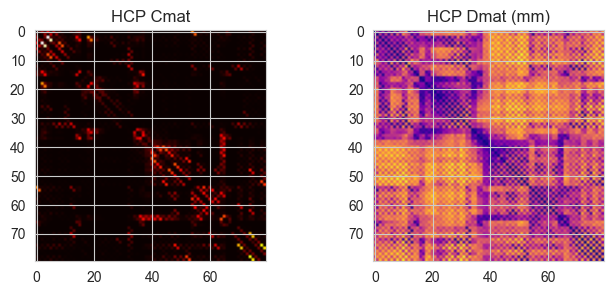

In [8]:
print('Cmat shape:', hcp['Cmat'].shape)   # (80, 80)
print('Dmat shape:', hcp['Dmat'].shape)   # (80, 80)
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].imshow(hcp['Cmat'], cmap='hot'); ax[0].set_title('HCP Cmat')
ax[1].imshow(hcp['Dmat'], cmap='plasma'); ax[1].set_title('HCP Dmat (mm)')
plt.show()

In [9]:
net = Network()
brainstate.nn.init_all_states(net)
indices = np.arange(0, 6e3 // (brainstate.environ.get_dt() / u.ms))
exes = brainstate.transform.for_loop(net.step_run, indices)

最后计算功能连接矩阵，并画出图，从中我们可以得到结构-功能相关性。

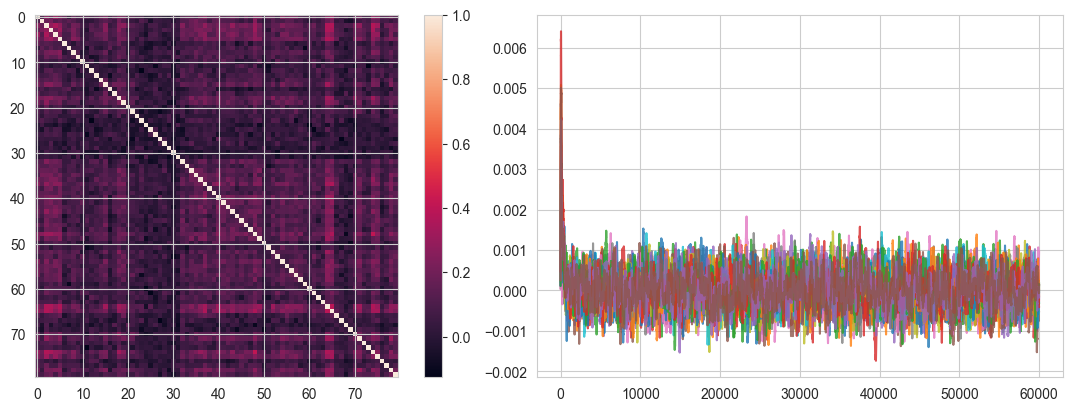

In [10]:
fig, gs = braintools.visualize.get_figure(1, 2, 4, 6)
ax1 = fig.add_subplot(gs[0, 0])
fc = braintools.metric.functional_connectivity(exes)
ax = ax1.imshow(fc)
plt.colorbar(ax, ax=ax1)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(indices, exes[:, ::5], alpha=0.8)
plt.show()

## Fit MEG data

这些都是基础的模拟和分析，接下来我们可以用上面得到的全脑数据和进行我们的任务，拟合MEG数据的功能连接性。
首先我们要先计算原始的采样率、脑区数，并对信号数据进行进一步封装

In [11]:
# 首先导入必要的工具
import xarray as xr

dt_ms = brainstate.environ.get_dt()
original_fs = 1000. / dt_ms 
num_regions = exes.shape[1]
time_points_orig = indices * dt_ms / 1000. 
time_points_orig = np.asarray(time_points_orig.magnitude)

region_labels = [f'Region_{i}' for i in range(num_regions)]
sim_signal_raw = xr.DataArray(
    exes, 
    dims=("time", "regions"), 
    coords={"time": time_points_orig, "regions": region_labels}
)

接下来，我们将原始模拟数据根据我们要研究的信号波段范围等进行一系列处理，包括重采样、带通滤波、幅度包络提取和低通滤波等，使研究的目标更明确，也跟MEG数据的处理同步。

首先是进行降采样，将超高 10 kHz 的仿真信号降采样至 100 Hz，以便后续分析可在 0–50 Hz 范围内进行，与真实 MEG 数据保持一致。

In [12]:
from scipy.signal import resample, butter, filtfilt, hilbert

In [13]:
target_fs = 100.0
ratio = len(time_points_orig) * target_fs / original_fs
num_samples_new = int(ratio.magnitude)
# resample
resampled_data, resampled_time = resample(sim_signal_raw, num_samples_new, t=time_points_orig)

sim_signal = xr.DataArray(
    resampled_data,
    dims=("time", "regions"),
    coords={"time": resampled_time, "regions": region_labels}
)
print(f"Original sampling rate: {original_fs} Hz. Resampled to: {target_fs} Hz.")

Original sampling rate: 10000.0 * kbecquerel Hz. Resampled to: 100.0 Hz.


接下来我们定义一个带通滤波器和一个低通滤波器，为后续特定频率的分析做好准备。

In [14]:
#  bandpass filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# low-pass filter
def butter_lowpass_filter(data, highcut, fs, order=3):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, [high], btype='low')
    y = filtfilt(b, a, data)
    return y

我们选择感兴趣的脑区之后，将信号滤波到 8–12 Hz 的 α 频段，应用 Hilbert 变换获得解析信号并提取瞬时幅度包络，最后进行低通滤波以揭示其慢动态。

In [15]:
target_region = 'Region_0' # 选择第一个脑区进行分析
signal_to_process = sim_signal.sel(regions=target_region).values

# bandpass filter
freq_band = [8.0, 12.0]    # α
filtered_signal = butter_bandpass_filter(signal_to_process, freq_band[0], freq_band[1], fs=target_fs)

# hilbert
analytic_signal = hilbert(filtered_signal)
signal_envelope = np.abs(analytic_signal)

# low-pass
low_pass_cutoff = 4.0
smoothed_envelope = butter_lowpass_filter(signal_envelope, low_pass_cutoff, fs=target_fs)

最后分别画出原始信号、带通滤波之后的振幅包络和低通滤波之后的振幅包络，得到我们最终拟合的MEG数据。

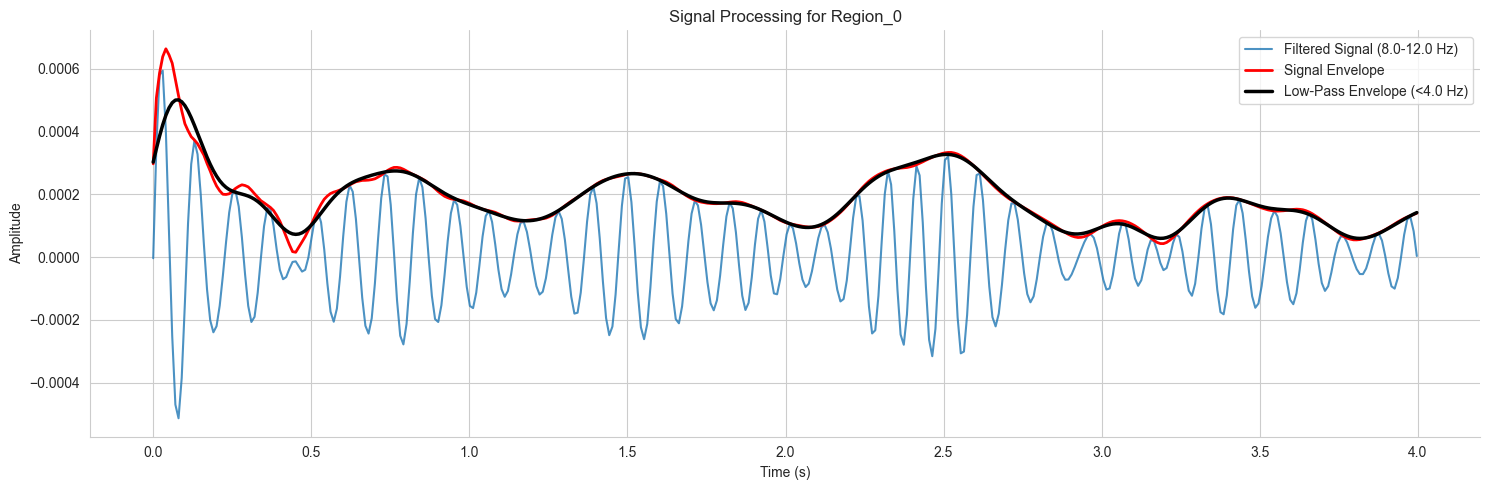

In [16]:
fig_signal, ax_signal = plt.subplots(figsize=(15, 5))
plot_duration_s = 4 # 画4秒
plot_timepoints = int(plot_duration_s * target_fs)
time_axis = sim_signal.time.values[:plot_timepoints]
ax_signal.plot(time_axis, filtered_signal[:plot_timepoints], label=f'Filtered Signal ({freq_band[0]}-{freq_band[1]} Hz)', alpha=0.8)
ax_signal.plot(time_axis, signal_envelope[:plot_timepoints], label='Signal Envelope', linewidth=2, color='red')
ax_signal.plot(time_axis, smoothed_envelope[:plot_timepoints], label=f'Low-Pass Envelope (<{low_pass_cutoff} Hz)', linewidth=2.5, color='black')
ax_signal.set_title(f'Signal Processing for {target_region}')
ax_signal.set_xlabel('Time (s)')
ax_signal.set_ylabel('Amplitude')
ax_signal.legend(loc='upper right')
ax_signal.spines['top'].set_visible(False)
ax_signal.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Process empirical data

接下来我们处理真实的MEG数据，首先是数据的加载，我们可以使用 HCP 数据集的静息态 MEG 数据，加载之后我们可以得到脑区标签，并计算原始采样率。

In [17]:
path = kagglehub.dataset_download("oujago/meg-data-samples")
meg_data = xr.open_dataset(os.path.join(path, 'rs-meg.nc'))

region_labels = meg_data.regions.values
sampling_rate = 1 / (meg_data.time[1] - meg_data.time[0]).item() # Calculate sampling rate from time coordinates
display(f"Data loaded with {len(region_labels)} regions. Sampling rate: {sampling_rate:.2f} Hz")

'Data loaded with 94 regions. Sampling rate: 100.00 Hz'

接下来我们可以设置一个控件，来自主选择感兴趣的脑区和研究波段

In [18]:
import ipywidgets as widgets

print('Select a region from the AAL2 atlas and a frequency range')
# Select a Region 
target = widgets.Select(options=region_labels, value='PreCG.L', description='Regions', 
                        tooltips=['Description of slow', 'Description of regular', 'Description of fast'], 
                        layout=widgets.Layout(width='50%', height='150px'))
display(target)

# Select Frequency Range
freq = widgets.IntRangeSlider(min=1, max=46, description='Frequency (Hz)', value=[8, 12], layout=widgets.Layout(width='80%'), 
                              style={'description_width': 'initial'})
display(freq)

plot_timepoints = 1000

meg_array = meg_data['__xarray_dataarray_variable__']
if meg_array.dims[0] != 'time':
    meg_array = meg_array.transpose('time', 'regions')    
fs = sampling_rate                                   
low, high = freq.value                              
plot_len = int(plot_timepoints)                     
time_vals = meg_array.time[:plot_len].values 

Select a region from the AAL2 atlas and a frequency range


Select(description='Regions', layout=Layout(height='150px', width='50%'), options=('PreCG.L', 'PreCG.R', 'SFG.…

IntRangeSlider(value=(8, 12), description='Frequency (Hz)', layout=Layout(width='80%'), max=46, min=1, style=S…

根据上面选择的脑区和波段，进行带通滤波，并画图表示，上图表示的是所选脑区的原始信号，下图表示的是带通滤波之后的信号和振幅包络。

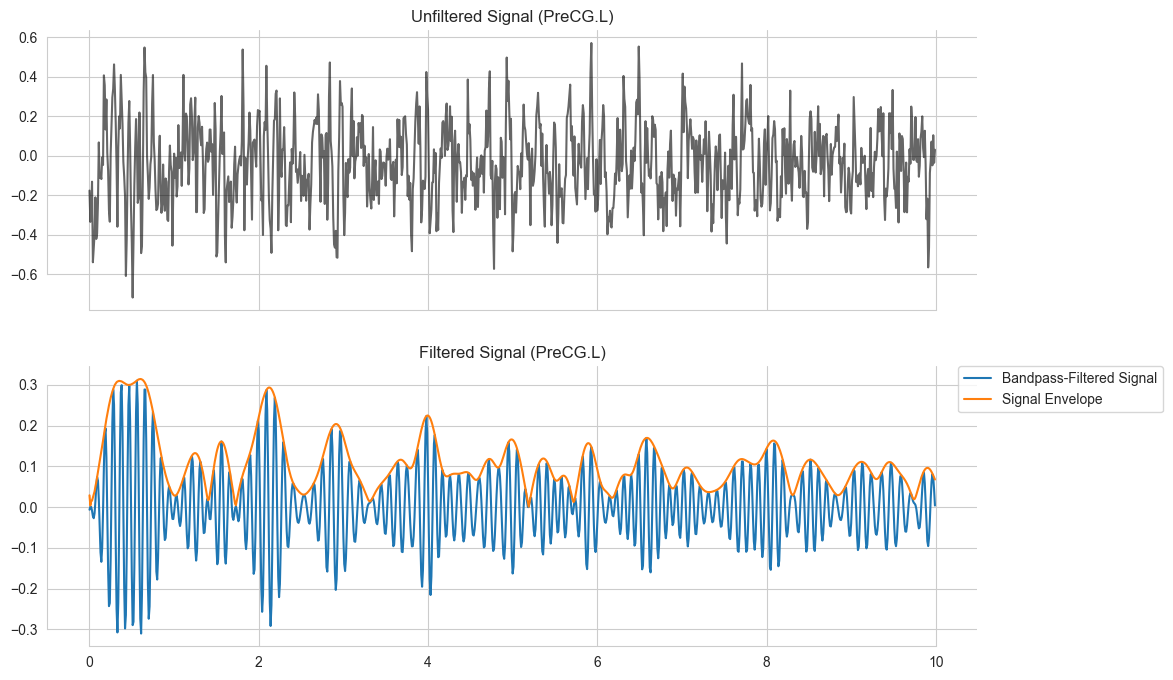

In [19]:
import seaborn as sns

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
y_raw_target = meg_array.sel(regions=target.value).values 
sns.lineplot(x=time_vals, y=y_raw_target[:plot_len], ax=ax[0], color='k', alpha=0.6)
ax[0].set_title(f'Unfiltered Signal ({target.value})')

# Band Pass Filter the Signal
y_filt_target = butter_bandpass_filter(y_raw_target, low, high, fs)
y_env_target  = np.abs(hilbert(y_filt_target))  

sns.lineplot(x=time_vals, y=y_filt_target[:plot_len], ax=ax[1], label='Bandpass-Filtered Signal')
sns.lineplot(x=time_vals, y=y_env_target[:plot_len], ax=ax[1], label='Signal Envelope')
ax[1].set_title(f'Filtered Signal ({target.value})');
ax[1].legend(bbox_to_anchor=(1.2, 1),borderaxespad=0)
sns.despine(trim=True)
plt.show()

接下来，我们对信号进行正交化处理。MEG 记录的是多个神经源的混合信号，也就是说电场扩散会引入虚假的功能连接，两个传感器可能捕捉到相同的潜在源。为解决这一问题，我们使用正交化去除每个目标区域信号中与参考区域相位相同的成分，仅保留该目标脑区独立的神经活动。这种正交化可提高 MEG 数据功能连接的空间特异性和可靠性。使用的公式如下：

$$
Y_{ix}(t, f) = \text{imag}\left(\frac{Y(t, f)}{X(t, f)^*}\right)
$$

Y 表示来自目标脑区的解析信号，使它相对于参考脑区 X 的信号进行正交化处理能够去除与 X 脑区相位相同的成分，仅保留 Y 中独立于 X 的神经活动部分。

In [20]:
# Orthogonalized signal envelope
print('Select a reference region for the orthogonalization')
# Select a Region 
referenz = widgets.Select(options=region_labels, value='PreCG.R', description='Regions',
                          tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
                          layout=widgets.Layout(width='50%', height='150px'))
display(referenz)

y_raw_reference = meg_array.sel(regions=referenz.value).values
y_filt_reference = butter_bandpass_filter(y_raw_reference, low, high, fs)

complex_target = hilbert(y_filt_target)
complex_reference = hilbert(y_filt_reference)
env_reference = np.abs(complex_reference)
env_target = np.abs(complex_target)

signal_conj_div_env = complex_reference.conj() / env_reference
orth_signal_imag = (complex_target * signal_conj_div_env).imag
orth_env = np.abs(orth_signal_imag)

Select a reference region for the orthogonalization


Select(description='Regions', index=1, layout=Layout(height='150px', width='50%'), options=('PreCG.L', 'PreCG.…

画图表示，上图指的是参考脑区的信号和振幅包络，下图是目标脑区的信号、振幅包络和正交化后的包络。注意：只有真实数据需要进行这个操作，模拟信号不需要。

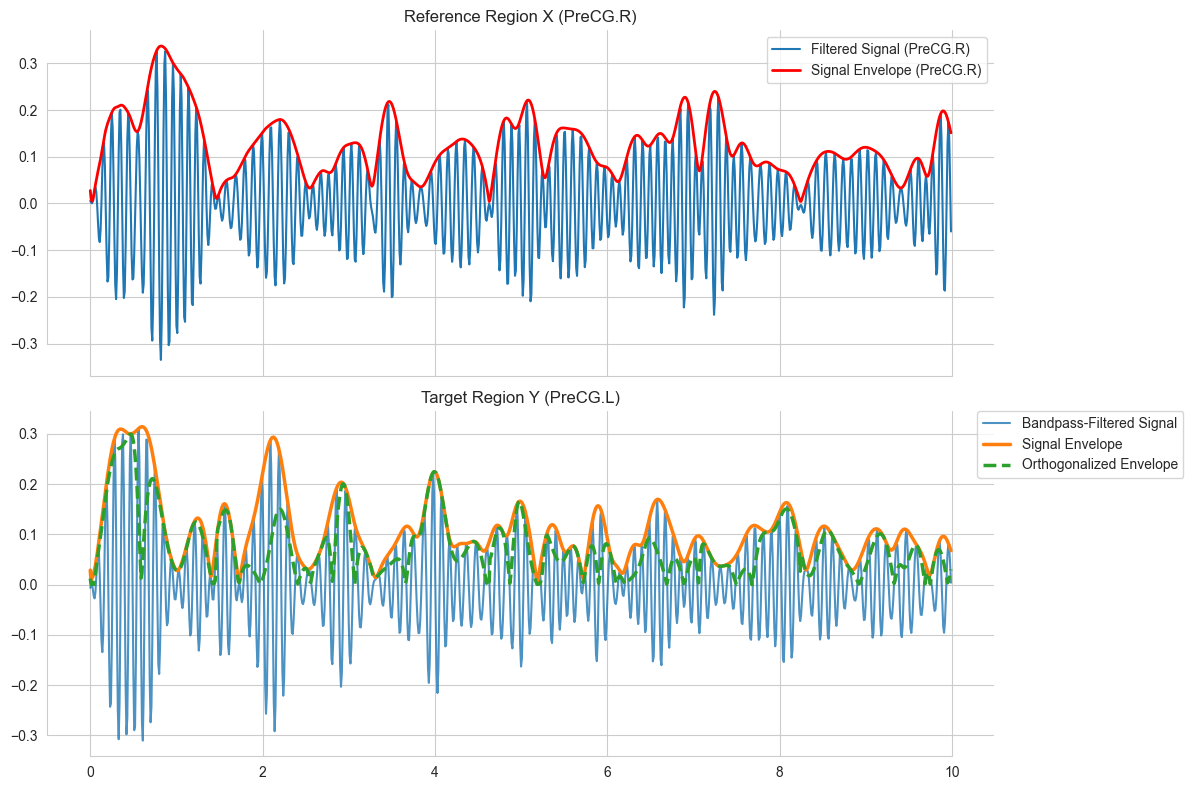

In [21]:
fig_final, ax_final = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax_final[0].plot(time_vals, y_filt_reference[:plot_len], label=f'Filtered Signal ({referenz.value})')
ax_final[0].plot(time_vals, env_reference[:plot_len], label=f'Signal Envelope ({referenz.value})', color='red', linewidth=2)
ax_final[0].set_title(f'Reference Region X ({referenz.value})')
ax_final[0].legend()

ax_final[1].plot(time_vals, y_filt_target[:plot_len], label='Bandpass-Filtered Signal', alpha=0.8)
ax_final[1].plot(time_vals, env_target[:plot_len], label='Signal Envelope', linewidth=2.5)
ax_final[1].plot(time_vals, orth_env[:plot_len], label='Orthogonalized Envelope', linewidth=2.5, linestyle='--')
ax_final[1].set_title(f'Target Region Y ({target.value})')
ax_final[1].legend(bbox_to_anchor=(1.2, 1), borderaxespad=0)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

对参考脑区的振幅包络和正交化后的目标脑区的振幅包络都通过低通滤波器，分离出他们的低频成分，得到最终的信号。

FloatSlider(value=1.0, description='Low-Pass Frequency (Hz)', layout=Layout(width='80%'), max=2.0, readout_for…

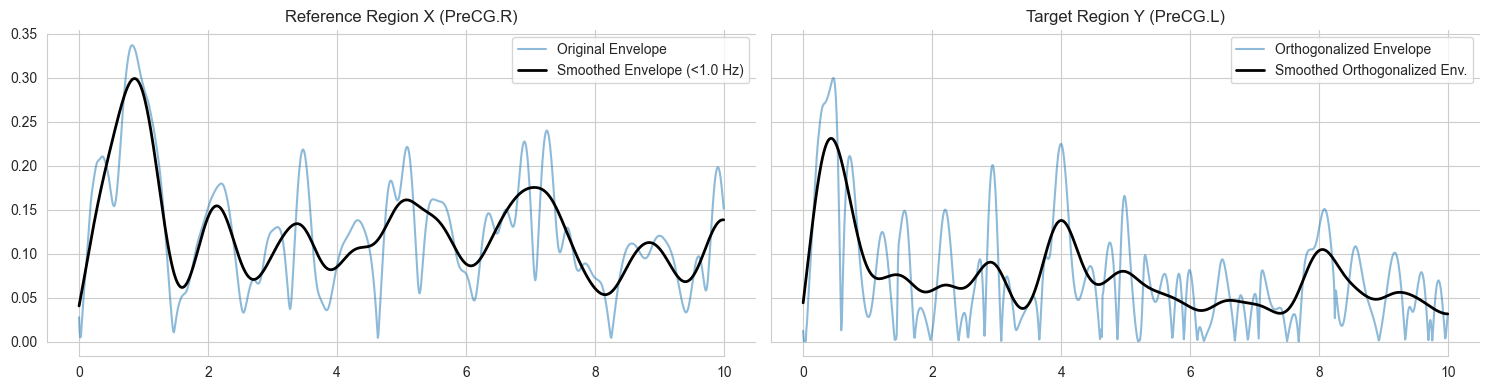


Orthogonalized envelope correlation between PreCG.R and PreCG.L: 0.20


In [22]:
low_pass = widgets.FloatSlider(value=1.0, min=0, max=2.0, step=0.1, description='Low-Pass Frequency (Hz)', 
                               disabled=False, readout=True, readout_format='.1f', layout=widgets.Layout(width='80%'), 
                               style={'description_width': 'initial'})
display(low_pass)

low_orth_env = butter_lowpass_filter(orth_env, highcut=low_pass.value, fs=fs)
low_signal_env = butter_lowpass_filter(env_reference, highcut=low_pass.value, fs=fs)

# Plot the smoothed envelopes for comparison
fig_corr, ax_corr = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# Plot for the reference region
ax_corr[0].plot(time_vals, env_reference[:plot_len], alpha=0.5, label='Original Envelope')
ax_corr[0].plot(time_vals, low_signal_env[:plot_len], color='black', lw=2, label=f'Smoothed Envelope (<{low_pass.value} Hz)')
ax_corr[0].set_title(f'Reference Region X ({referenz.value})')
ax_corr[0].legend()

# Plot for the target region
ax_corr[1].plot(time_vals, orth_env[:plot_len], alpha=0.5, label='Orthogonalized Envelope')
ax_corr[1].plot(time_vals, low_orth_env[:plot_len], color='black', lw=2, label='Smoothed Orthogonalized Env.')
ax_corr[1].set_title(f'Target Region Y ({target.value})')
ax_corr[1].legend()

sns.despine(trim=True)
plt.tight_layout()
plt.show()

correlation = np.corrcoef(low_orth_env, low_signal_env)[0, 1]
print(f'\nOrthogonalized envelope correlation between {referenz.value} and {target.value}: {correlation:.2f}')

## Compute the functional connectivity matrix

接下来对经过了一系列处理的模拟信号和真实信号计算各自的功能连接矩阵。具体操作是定义一个函数，遍历每一对脑区，执行前面的所有步骤：提取包络、正交化、带通滤波和低通滤波，并返回成对包络相关系数的功能连接矩阵。

In [23]:
def calculate_orthogonalized_fc(meg_data, band, fs, low_pass_cutoff):
    num_regions = meg_data.shape[1]
    
    # Z-score standardize the raw signals from all brain regions to ensure robustness of the results.
    meg_array_mean = meg_data.mean(dim='time')
    meg_array_std = meg_data.std(dim='time')
    meg_data_normalized = (meg_data - meg_array_mean) / meg_array_std
    
    # Apply band-pass and low-pass filtering
    y_filt_all = butter_bandpass_filter(meg_data_normalized.values, band[0], band[1], fs)
    complex_all = hilbert(y_filt_all, axis=0)
    env_all = np.abs(complex_all) 
    conj_div_env_all = complex_all.conj() / env_all
    low_pass_env_all = butter_lowpass_filter(env_all, highcut=low_pass_cutoff, fs=fs)

    # Iteratively compute orthogonalization and correlation
    fc_matrix = np.zeros((num_regions, num_regions))
    
    progress = widgets.IntProgress(min=0, max=num_regions, description='Computing FC:',
                                   layout=widgets.Layout(width='80%'), style={'description_width': 'initial'})
    display(progress)
    
    for i in range(num_regions):
        complex_target = complex_all[:, i]
        orth_signal_imag = (complex_target[:, np.newaxis] * conj_div_env_all).imag
        orth_env = np.abs(orth_signal_imag)
        low_pass_orth_env = butter_lowpass_filter(orth_env, highcut=low_pass_cutoff, fs=fs)
        corr_mat = np.corrcoef(low_pass_orth_env.T, low_pass_env_all.T)
        corr_row = np.diag(corr_mat, k=num_regions)
        fc_matrix[i, :] = corr_row
        progress.value += 1
        
    fc_matrix = (fc_matrix + fc_matrix.T) / 2
    np.fill_diagonal(fc_matrix, 0)
    
    display("FC Matrix calculation complete.")
    return fc_matrix

定义一个功能连接矩阵可视化函数，画成标准的红蓝对称热图。

In [24]:
def plot_fc_heatmap(fc_matrix, labels, title, ax):
    vmax = np.max(np.abs(fc_matrix))
    
    sns.heatmap(
        fc_matrix,
        square=True,
        ax=ax,
        cmap='RdBu_r',
        vmin=-vmax,
        vmax=vmax,
        cbar_kws={"shrink": .8}
    )
    
    num_regions = len(labels)
    tick_spacing = max(1, num_regions // 20)
    
    cleaned_labels = [str(label).replace('.L', '').replace('.R', '') for label in labels]
    
    ax.set_xticks(np.arange(0, num_regions, tick_spacing))
    ax.set_yticks(np.arange(0, num_regions, tick_spacing))
    ax.set_xticklabels(cleaned_labels[::tick_spacing], rotation=90, fontsize=8)
    ax.set_yticklabels(cleaned_labels[::tick_spacing], rotation=0, fontsize=8)
    ax.set_title(title)

计算真实信号的FC矩阵并画图展示

IntProgress(value=0, description='Computing FC:', layout=Layout(width='80%'), max=94, style=ProgressStyle(desc…

'FC Matrix calculation complete.'


Plotting FC Matrix for real MEG data (Default Order)...


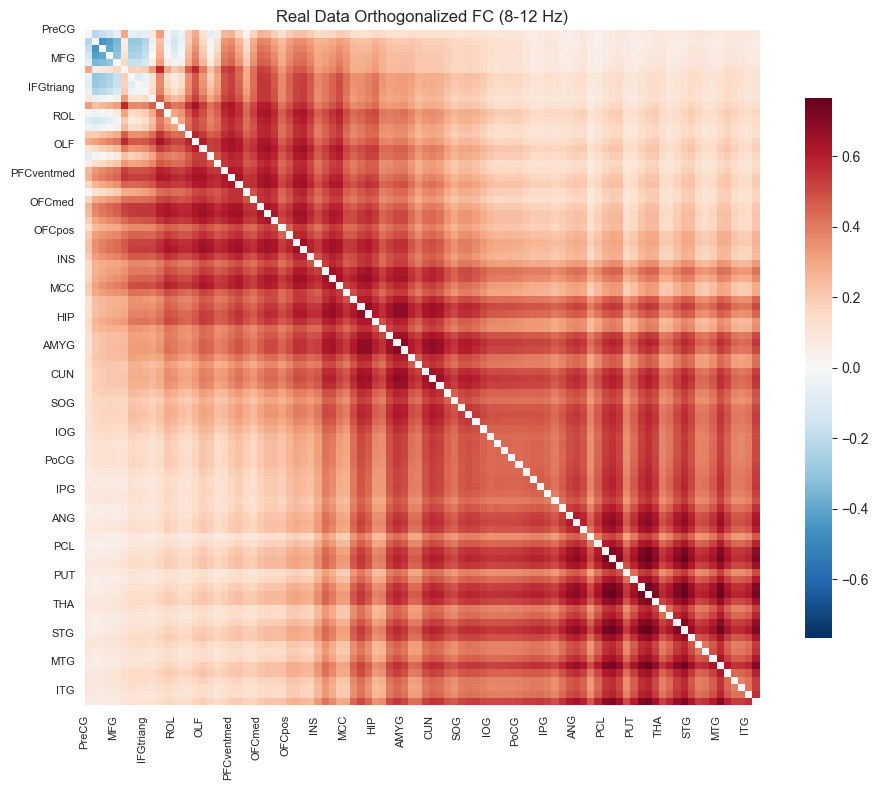

In [25]:
# Execute the function with the parameters from the widgets
fc_matrix = calculate_orthogonalized_fc(
    meg_data=meg_array, 
    band=freq.value, 
    fs=fs, 
    low_pass_cutoff=low_pass.value
)

print("\nPlotting FC Matrix for real MEG data (Default Order)...")

fig_real, ax_real = plt.subplots(figsize=(10, 8))
plot_fc_heatmap(
    fc_matrix=fc_matrix,
    labels=region_labels, 
    title=f'Real Data Orthogonalized FC ({freq.value[0]}-{freq.value[1]} Hz)',
    ax=ax_real
)
plt.tight_layout()
plt.show()

计算模拟信号的FC矩阵并画图展示


Please select parameters for the simulation FC calculation:


IntRangeSlider(value=(8, 12), description='Frequency (Hz)', layout=Layout(width='80%'), max=45, min=1, style=S…

FloatSlider(value=2.0, description='Low-Pass (Hz)', layout=Layout(width='80%'), max=4.0, readout_format='.1f',…

IntProgress(value=0, description='Computing FC:', layout=Layout(width='80%'), max=80, style=ProgressStyle(desc…

'FC Matrix calculation complete.'

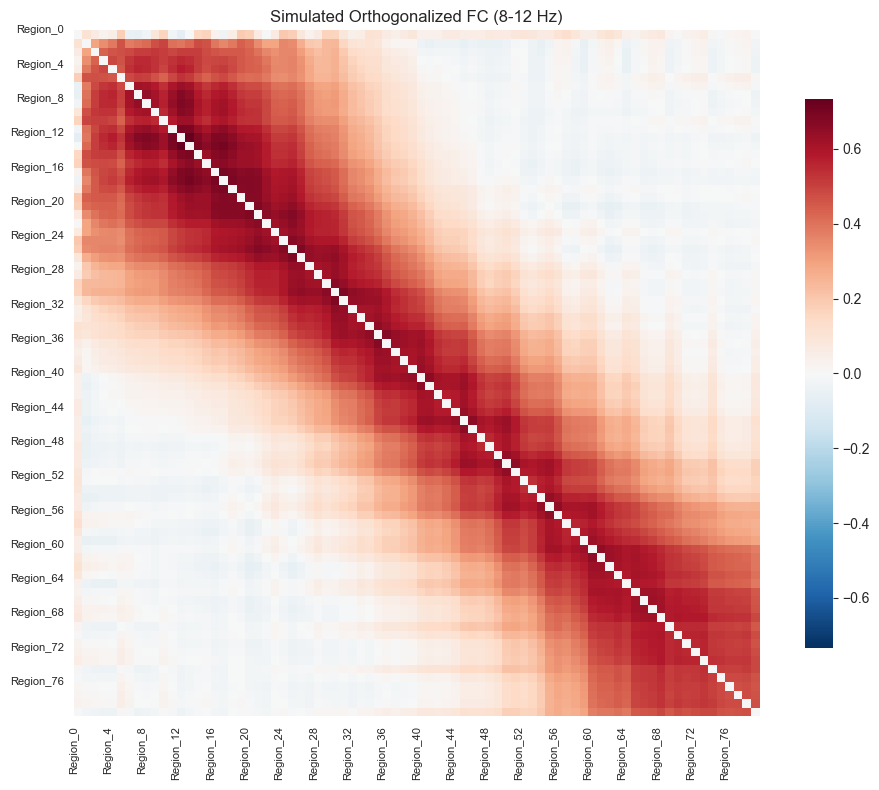

In [26]:
print("\nPlease select parameters for the simulation FC calculation:")
sim_freq_band = widgets.IntRangeSlider(
    value=[8, 12], min=1, max=45, description='Frequency (Hz)',
    layout=widgets.Layout(width='80%'), style={'description_width': 'initial'}
)
sim_low_pass = widgets.FloatSlider(
    value=2.0, min=0, max=4.0, step=0.1, description='Low-Pass (Hz)',
    readout=True, readout_format='.1f',
    layout=widgets.Layout(width='80%'), style={'description_width': 'initial'}
)
display(sim_freq_band)
display(sim_low_pass)

fc_matrix_sim = calculate_orthogonalized_fc(
    meg_data=sim_signal,
    band=sim_freq_band.value,
    fs=target_fs,
    low_pass_cutoff=sim_low_pass.value
)

sim_labels = sim_signal.regions.values
fig_sim, ax_sim = plt.subplots(figsize=(10, 8))
plot_fc_heatmap(
    fc_matrix=fc_matrix_sim,
    labels=sim_labels, 
    title=f'Simulated Orthogonalized FC ({sim_freq_band.value[0]}-{sim_freq_band.value[1]} Hz)',
    ax=ax_sim
)
plt.tight_layout()
plt.show()

## Compute similarity

最后将仿真与真实的功能连接矩阵展平为向量，计算它们的皮尔逊相关系数，并用柱状图展示模型拟合度，从而直观评估仿真网络对经验 MEG 功能连接的拟合程度。


Comparing the 80x80 simulated FC with the corresponding subset of the real MEG FC.


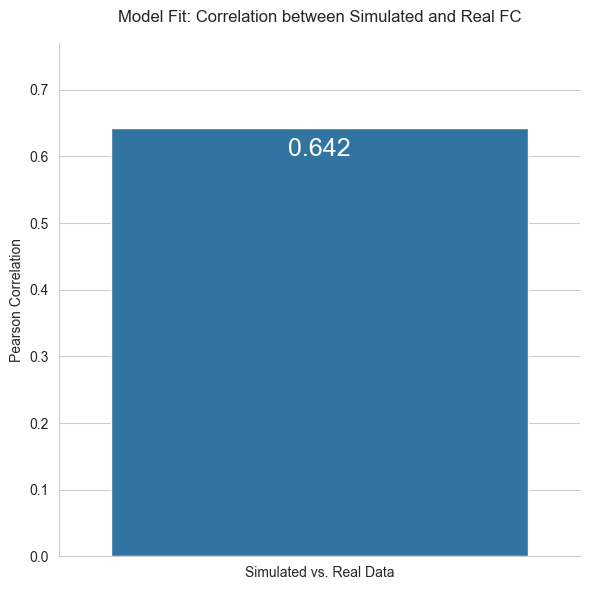

The correlation between the simulated FC and the real MEG data FC is: 0.642


In [28]:
num_sim_regions = fc_matrix_sim.shape[0]
fc_matrix_real_matched = fc_matrix[:num_sim_regions, :num_sim_regions]
print(f"\nComparing the {num_sim_regions}x{num_sim_regions} simulated FC with the corresponding subset of the real MEG FC.")
indices_triu = np.triu_indices(num_sim_regions, k=1)
real_fc_flat = fc_matrix_real_matched[indices_triu]
sim_fc_flat = fc_matrix_sim[indices_triu]

# Calculate the Pearson correlation between the two flattened FC vectors
sim_vs_real_corr = np.corrcoef(real_fc_flat, sim_fc_flat)[0, 1]
fig_comp, ax_comp = plt.subplots(figsize=(6, 6))

splot = sns.barplot(
    x=['Simulated vs. Real Data'],
    y=[sim_vs_real_corr],
    ax=ax_comp
)

ax_comp.set_ylabel('Pearson Correlation')
ax_comp.set_title('Model Fit: Correlation between Simulated and Real FC', pad=15)
ax_comp.set_ylim(0, max(0.5, sim_vs_real_corr * 1.2)) 

# Add the correlation value as text on the bar
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.3f'), 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='center', 
        size=18, color='white',
        xytext=(0, -15), 
        textcoords='offset points'
    )

sns.despine()
plt.tight_layout()
plt.show()
print(f"The correlation between the simulated FC and the real MEG data FC is: {sim_vs_real_corr:.3f}")